# EELS SFO Project - Autoencoder

**Description about data**

Total of 90,000 spectra was provided: 
- 2 sets of 10 spectrum images with 300 x 30 spatial coordinates.
- Each spatial coordinate has 3710 energy channels. 
- For each spectra, the initial energy-loss value is 387.5 eV with energy width of 0.125 eV i.e. [387.5 : 851.25 : 0.125].

> initial state (SrFeO3 with Fe4+) 

> annealed state (SrFeO2.5 with Fe3+)

These two sets are provided to train an ML model. The goal is that this model will take any spectral data (single spectrum with very small number of signal counts) and spit out the corresponding oxidation states (4+/3+). So one way to test this is by sampling from the 90,000 spectral data to be predicted and cross validate. The question can be: (1) what is the lowest number of spectra needed before the model can no longer distinguish, (2) what is the fastest scan speed, (3) resistant to noise, ... and so on with the same idea.

* This would be considered supervised learning. But what Josh is doing is to see how the spectra changes over the image (in their spatial distribution). ML will tells you the statistical relationship/distribution within the image.


**Meeting with Mitra (10/17/19)** 

Josh has similar projects before that can be utilized
- Autoencoder: learning from low dimensional layers and recreate the image
- Reccurrence: eacch neuron evaluate timestep and passes the data into the cycle
- Utilize LSTM to the RNN
- Strong L1 regularization to impose sparsity to that layer

Recommendations:
- PCA doesn't look helpful. May need to use CNN.
- Pre-filtering will require trials and errors.
- Gaussian regression + sample on region of interest over 100 points 
- Difficulty is going to be on the preprocessing of the data
- Transformer network --> 1D convolution NN with attention has now replaced LSTM, rigorously proved that Attention is much more superior.

Data Collection Process:
- Fourier Transform (FFT) not done so much with EELS. 
- FFT Find the high frequency to pull out. But, in practice, we did not find FFT to be helpful.


## Some resources to read on Autoencoder

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import hyperspy.api as hs
import scipy
import seaborn as sns

In [3]:
'''
loading initial data
'''
data_initial = hs.load(r'G:\Shared drives\Datasets\High-Speed EELS\Initial SIs\*.dm4', signal_type="EELS", stack=False)
#print(data_initial[0].metadata)
#print(data_initial[0].axes_manager)

In [4]:
'''
loading annealed data
'''
data_anneal = hs.load(r'G:\Shared drives\Datasets\High-Speed EELS\annealed SIs\*.dm4', signal_type="EELS", stack=False)
#print(data_anneal[0].metadata)
#print(data_anneal[0].axes_manager)

In [ ]:
'''
setting x-axis label
'''
for spectra in data_initial:
    corrected_xaxis = np.array([0.125*j+387.5 for j in range(spectra.data.shape[2])])
    print(len(corrected_xaxis), corrected_xaxis)
    break

In [5]:
'''
Adding dark references to spectra
'''
def add_dark_ref(data, dark_ref):
    for k, spectra in enumerate(data):
        y = len(spectra.data)
        x = len(spectra.data[0])
        data[k].corrected = np.float32(np.copy(spectra.data))
        for i in range(y):
            for j in range(x):
                data[k].corrected[i][j] = np.sum([spectra.data[i][j],dark_ref.data], axis=0)
        #print("Completed "+str(k))
    print("Completed")

In [6]:
dark_ref = hs.load(r'G:\Shared drives\Datasets\High-Speed EELS\dark reference.dm4', signal_type="EELS")
print("Shape of dark ref spectra: " + str(dark_ref.data.shape))

add_dark_ref(data_initial, dark_ref)
add_dark_ref(data_anneal, dark_ref)

Shape of dark ref spectra: (3710,)
Completed
Completed


**Background Subtraction based on power law fit**

> Fit the equation "I = A*E^r"
    * I is the measured intensity, 
    * A is a constant
    * E is the energy-loss value (eV)
    * r is an exponent (usually around 3)
Select an energy window (around 50 eV wide), a few eV before the edge of interest to fit A and r

In [7]:
'''
Background Subtraction & Filter noise (Savizky-Golay Filter)

https://github.com/trygvrad/RNN-on-EELS-data/blob/master/EELScodes
https://scipy-cookbook.readthedocs.io/items/FittingData.html
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
'''
import scipy.optimize # curve_fit
from scipy.fftpack import fft

def scaledExp(x,a,b):
    return a*np.exp((np.array(x))*b)

def subtractExpBackground(data1,xrange=None):
    data2 = np.float32(np.copy(data1))
    x = range(data1.shape[2])
    # fit over the entire spectra by default
    if type(xrange) == type(None):
        xrange = x 
    for i in range(data1.shape[0]):
        for j in range(data1.shape[1]):
            popt, pcov = scipy.optimize.curve_fit(scaledExp,xrange,data2[i,j,xrange], p0 = [4.19082741e+02, -1.93625569e-03])
            data2[i,j] = data2[i,j]-scaledExp(x,popt[0],popt[1])
            # print(popt)
    return data2

def subtract_bckgrnd_and_filter(data):
    backgroundregion = np.arange(400,1000,1)  # this is approximately 50eV wide, over the region before ROI
    for k,spectra in enumerate(data): 
        data[k].adjusted = subtractExpBackground(spectra.corrected,backgroundregion)
        data[k].SG_filter = scipy.signal.savgol_filter(data[k].adjusted, 51, 3) # window size 50, polynomial order 3

In [8]:
subtract_bckgrnd_and_filter(data_initial)
subtract_bckgrnd_and_filter(data_anneal)

In [ ]:
'''
generating FFT dataset

You can plot this out. What you will see in this dataset however is that 
there is no real patterns of noise that must be removed i.e. after doing 
FTT, you may be able to pick out certain features in the graph that may
correspond to noise to be removed.

"The output of the FFT is a complex vector containing information about 
the frequency content of the signal. The magnitude tells you the strength 
of the frequency components relative to other components. The phase tells 
you how all the frequency components align in time." ~ Mathworks.com
'''
def apply_FFT(data):
    for k,spectra in enumerate(data): 
        # Applying fast fourier transform
        data[k].FFT = fft(data[k].SG_filter)
        #print("enumerated "+str(k))
    print("Completed")

In [ ]:
#apply_FFT(data_initial)
#apply_FFT(data_anneal)
#plt.plot(data_initial[0].FFT)
#plt.plot(data_anneal[0].FFT)

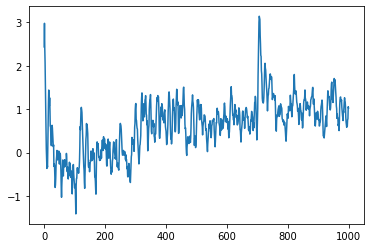

In [11]:
plt.plot(data_anneal[0].resample[20][20])

In [9]:
'''
Downsampling the image 
https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.downscale_local_mean
'''
def downsample(data, N):
    from scipy.signal import resample
    
    for k,sp in enumerate(data):
        data[k].resample = np.zeros((sp.SG_filter.shape[0],sp.SG_filter.shape[1], N))
        for i in range(sp.SG_filter.shape[0]):
            for j in range(sp.SG_filter.shape[1]):
                data[k].resample[i][j] = resample(sp.SG_filter[i][j][:], N)      


In [10]:
N = 1000  # number of samples in the resampled set

downsample(data_initial, N)
downsample(data_anneal, N)

In [83]:
'''
Cutting region of interest to be analyzed
-----------------------

anly_range = 100 raw data points
O_range = starts @ 1100 [1100:1500]
Fe_range = starts @ 2500 [2500:2900]

'''
def cut_ROI(data, N_resampled):
    import math
    N_0 = data[0].data.shape[2]
    N_1 = N_resampled  # number resampled (have to match previous resampling rate)
    anly_range = 88

    for k,spectra in enumerate(data):
        data[k].O_range = np.zeros((spectra.resample.shape[0], spectra.resample.shape[1], math.ceil((anly_range)/N_0*N_1)))
        data[k].Fe_range = np.zeros((spectra.resample.shape[0], spectra.resample.shape[1], math.ceil((anly_range)/N_0*N_1)))
        for i in range(spectra.resample.shape[0]):
            for j in range(spectra.resample.shape[1]):
                data[k].O_range[i][j] = spectra.resample[i][j][math.ceil(1100/N_0*N_1):math.ceil((1100+anly_range)/N_0*N_1)]
                data[k].Fe_range[i][j] = spectra.resample[i][j][math.ceil(2500/N_0*N_1):math.ceil((2500+anly_range)/N_0*N_1)]
        print(k, (data[k].O_range.shape, data[k].Fe_range.shape))

In [84]:
cut_ROI(data_initial, N)
cut_ROI(data_anneal, N)

0 ((30, 300, 24), (30, 300, 24))
1 ((30, 300, 24), (30, 300, 24))
2 ((30, 300, 24), (30, 300, 24))
3 ((30, 300, 24), (30, 300, 24))
4 ((30, 300, 24), (30, 300, 24))
5 ((30, 300, 24), (30, 300, 24))
6 ((30, 300, 24), (30, 300, 24))
7 ((30, 300, 24), (30, 300, 24))
8 ((30, 300, 24), (30, 300, 24))
9 ((30, 300, 24), (30, 300, 24))
0 ((30, 300, 24), (30, 300, 24))
1 ((30, 300, 24), (30, 300, 24))
2 ((30, 300, 24), (30, 300, 24))
3 ((30, 300, 24), (30, 300, 24))
4 ((30, 300, 24), (30, 300, 24))
5 ((30, 300, 24), (30, 300, 24))
6 ((30, 300, 24), (30, 300, 24))
7 ((30, 300, 24), (30, 300, 24))
8 ((30, 300, 24), (30, 300, 24))
9 ((30, 300, 24), (30, 300, 24))


In [87]:
'''
aggregate data along 2D space
'''
def aggre_plot(data, N, name:str=''):
    import math
    N_0 = data[0].data.shape[2]
    N_1 = N  # number resampled (have to match previous resampling rate)
    anly_range = 88
    
    exp_adjusted_data = {}
    aggregated_data_x = {}
    aggregated_data_xy = {}
    for k,spectra in enumerate(data):
        exp_adjusted_data[k] = spectra.resample
        aggregated_data_x[k] = sum(exp_adjusted_data[k]).transpose()
        aggregated_data_xy[k] = np.sum(aggregated_data_x[k],axis=1)
        #print("Shape of XY aggregate: ", str(k), str(aggregated_data_xy[k].shape))

    '''
    plot aggregated spectral data
    '''
    new_xaxis = np.linspace(387.5, 783.75, num=N)  # This is the range of energy loss given by the EELS machine
    for k,key in enumerate(aggregated_data_xy):
        ax1.plot(new_xaxis, aggregated_data_xy[key], label='spectra '+str(key))
        ax2.plot(aggregated_data_xy[key][math.ceil(1100/N_0*N_1):math.ceil((1100+anly_range)/N_0*N_1)], label='O K-edge'+name) # O K-edge 
        ax3.plot(aggregated_data_xy[key][math.ceil(2500/N_0*N_1):math.ceil((2500+anly_range)/N_0*N_1)], label='Fe L-edge'+name) # Fe L-edge
        #ax2.plot(corrected_xaxis[1000:1500], aggregated_data_xy[key][1000:1500], label='O K-edge') # O K-edge 
        #ax3.plot(corrected_xaxis[2500:3000], aggregated_data_xy[key][2500:3000], label='Fe L-edge') # Fe L-edge
        if k>5:
            break

    '''
    configure the plot
    '''
    ax1.set_title("Average Energy Loss")
    #ax1.title.set_text('Overall')
    #ax2.title.set_text('Over O peaks')
    #ax3.title.set_text('Over Fe Peaks')
    #ax4.title.set_text('Except the first few eV')
    plt.xlabel("Energy Loss (eV)")
    plt.ylabel("counts")
    #plt.legend()

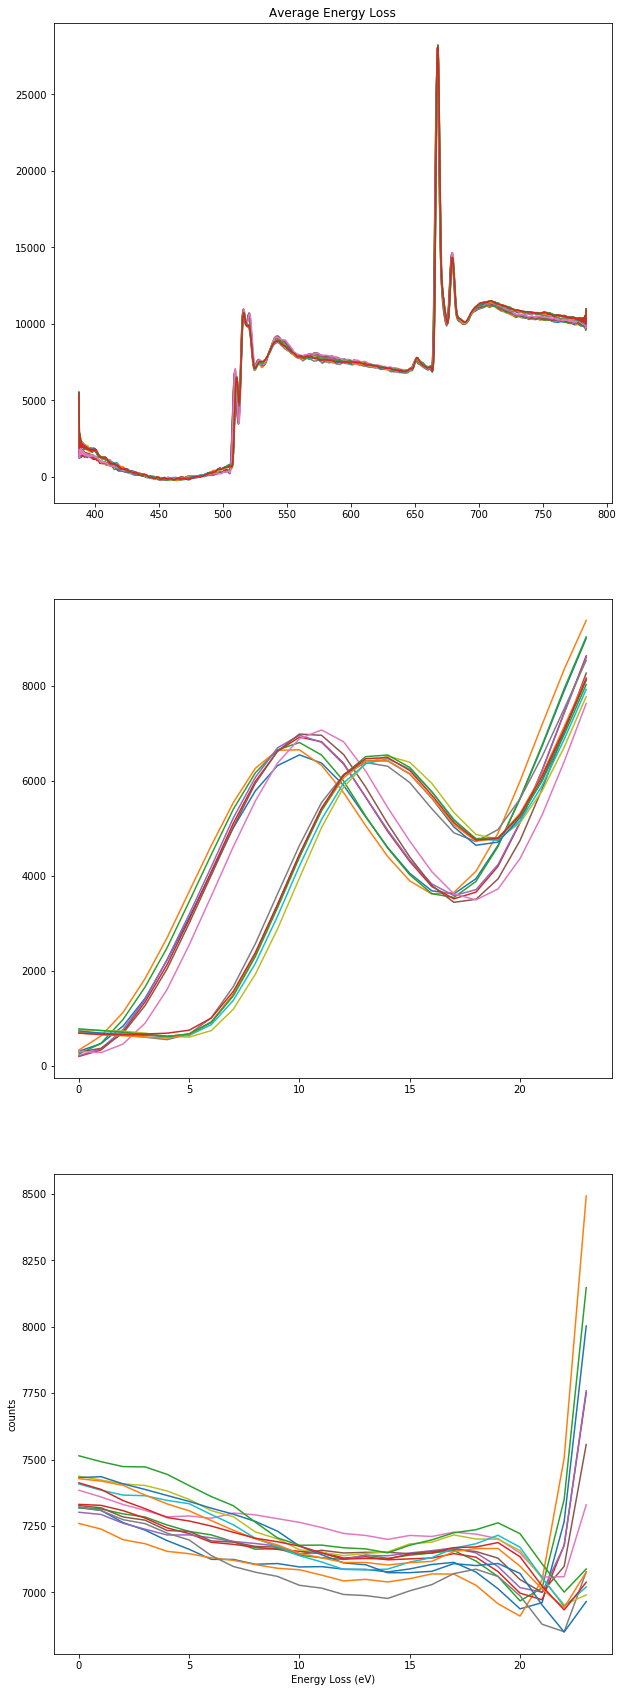

In [88]:
fig, (ax1,ax2,ax3) = plt.subplots(3, figsize=(10,30))
aggre_plot(data_initial, N, name='Initial')
aggre_plot(data_anneal, N, name='Anneal')
plt.show()

In [119]:
'''
Plotting out the similarity for each embedding
'''

#import matplotlib as m
#cdict = {
#  'red'  :  ( (0.0, 0.25, .25), (0.02, .59, .59), (1., 1., 1.)),
#  'green':  ( (0.0, 0.0, 0.0), (0.02, .45, .45), (1., .97, .97)),
#  'blue' :  ( (0.0, 1.0, 1.0), (0.02, .75, .75), (1., 0.45, 0.45))
#}
#cm = m.colors.LinearSegmentedColormap('my_colormap', cdict, 1024)

def plot_pcolor(data,numPCAcomp=25):
    fig= plt.figure(figsize=(50,50))
    ax=[]

    for i in range(numPCAcomp):
        ax.append(fig.add_subplot(5,5,i+1))
        # plotting pseudocolor with global min/max scale
        pcolor=ax[-1].pcolor(data[:,:,i])
                             #vmin=np.amin(PCA_Embeddings), 
                             #vmax=np.amax(PCA_Embeddings),
                             #cmap=cm
        ax[i].set_title('Channel = '+str(i))
        #ax[-1].axis('scaled')
        ax[-1].invert_yaxis()
        #pcolor.set_clim(0, 2)
        fig.colorbar(pcolor)

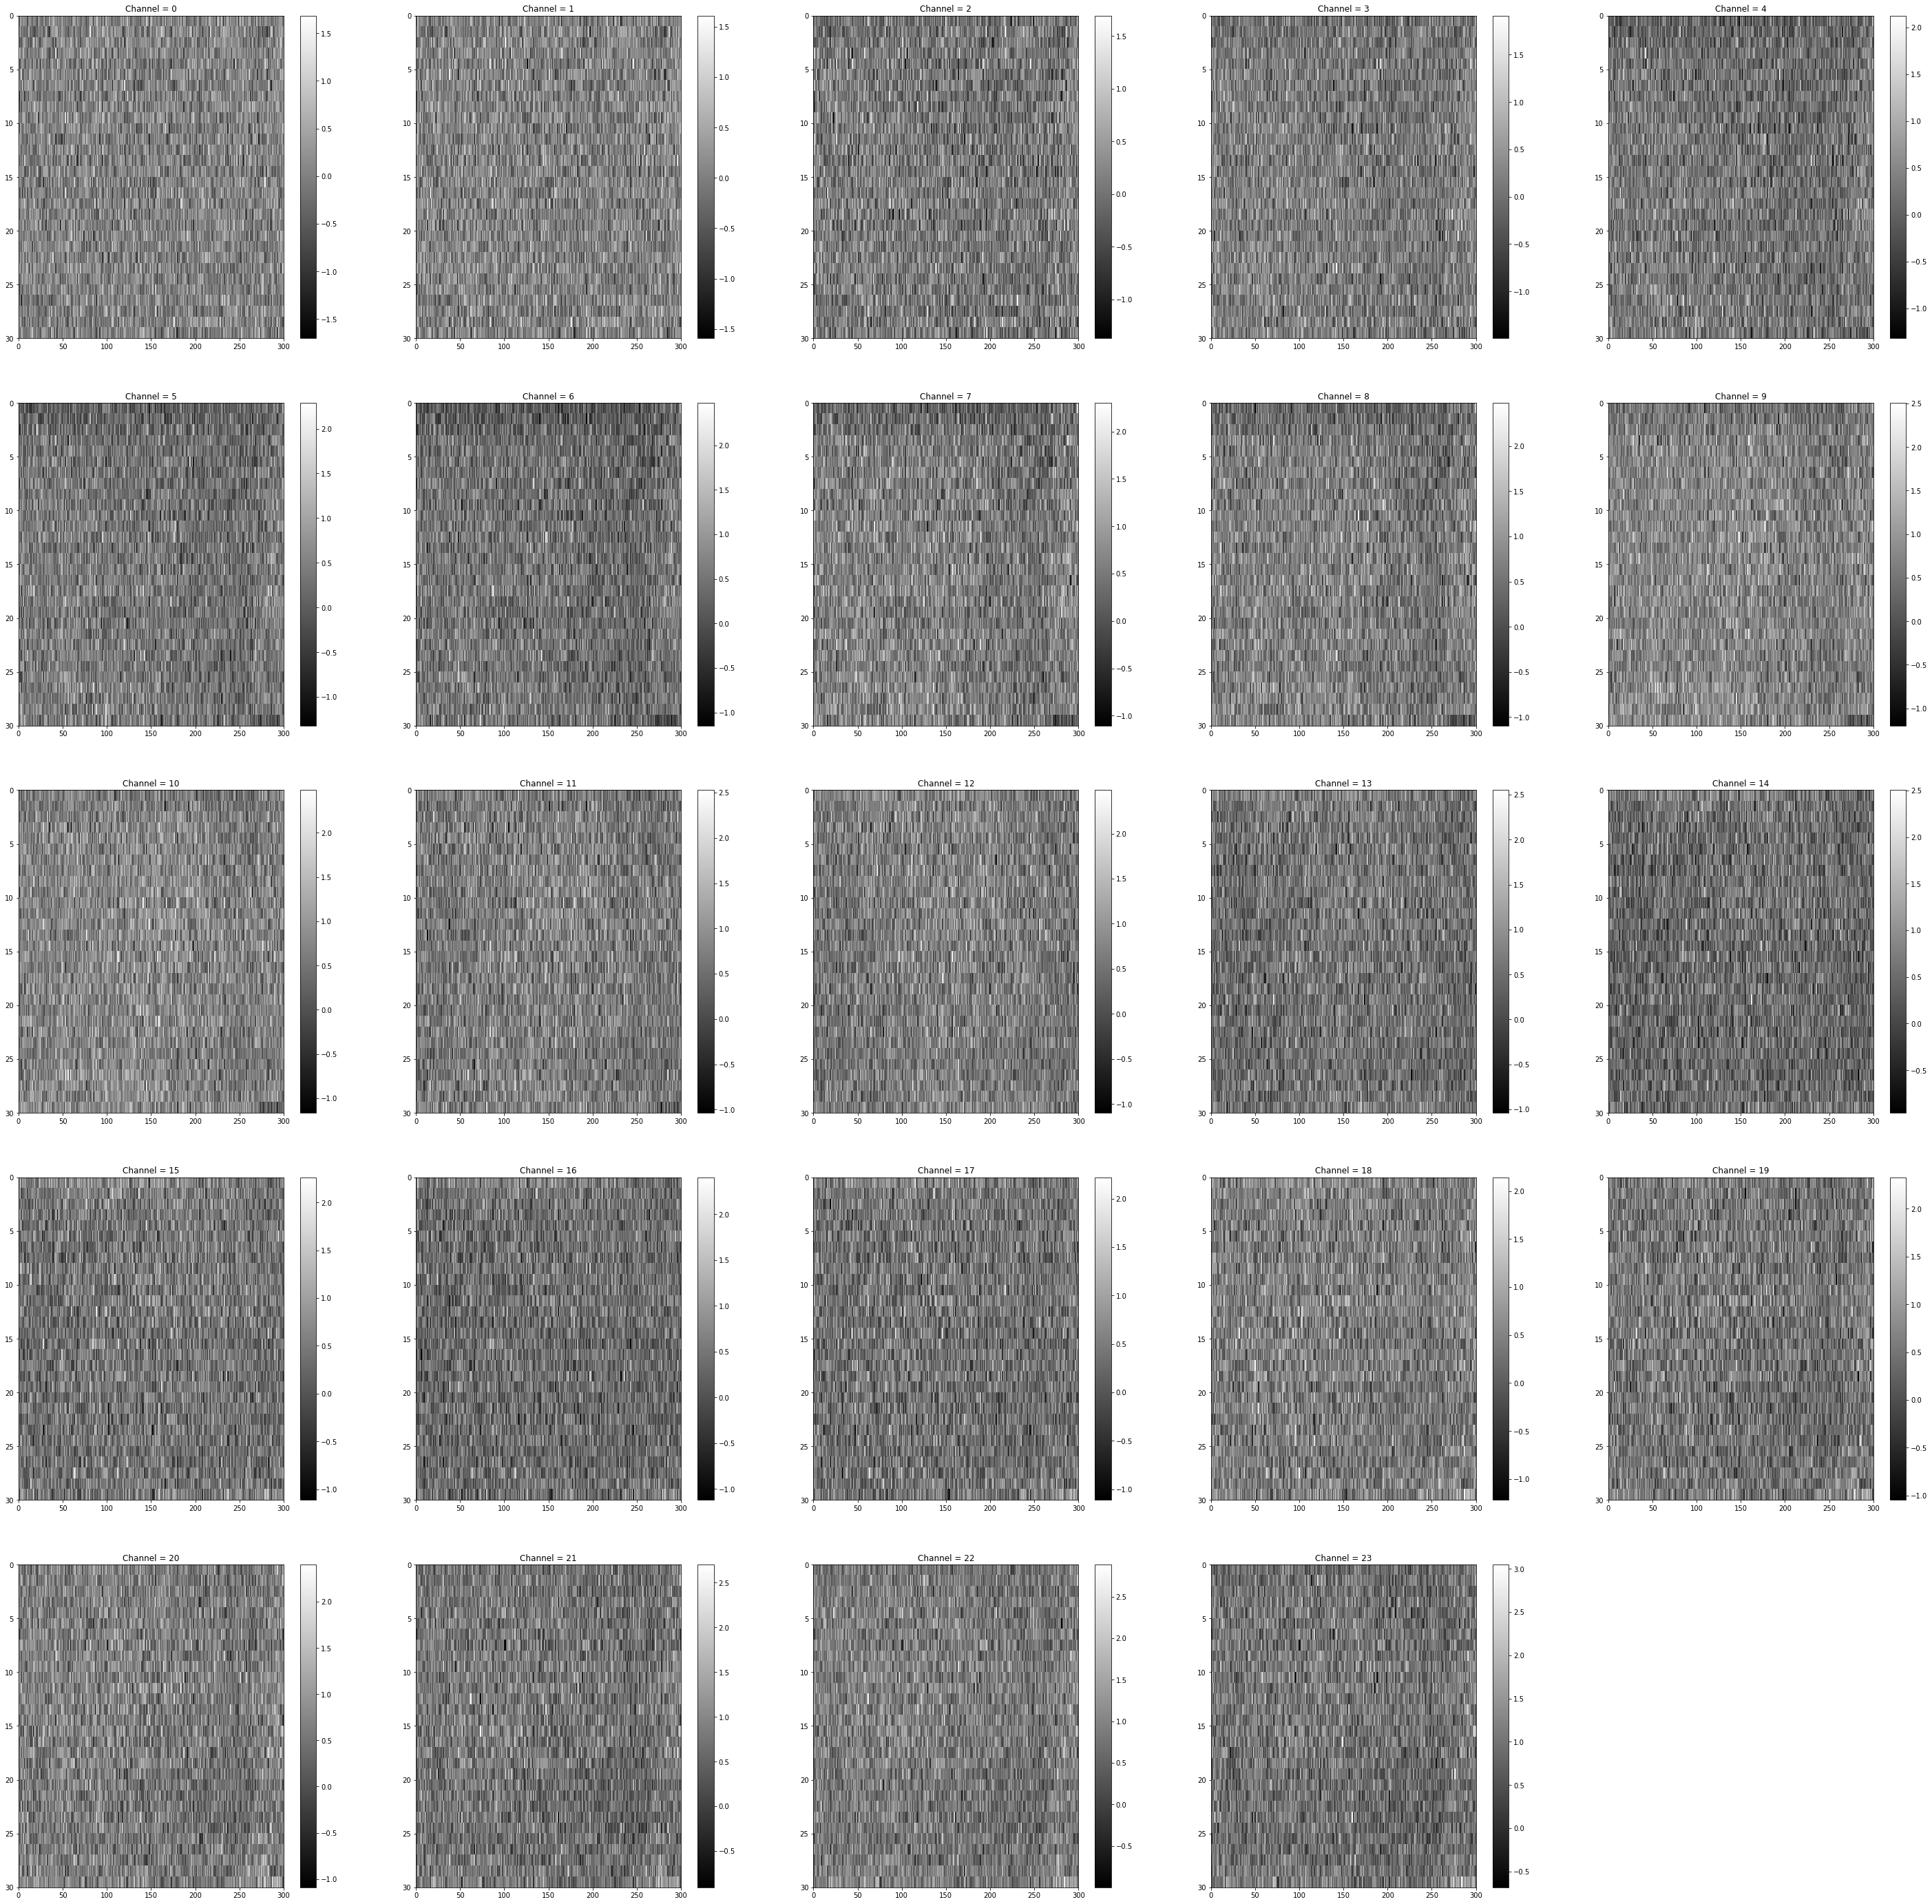

In [120]:
plot_pcolor(data_initial[0].O_range, 24)

## Autoencoder
- reconstructing 30x300 image 

Essentially, I'm trying to train an encoder and decoder

### Procedure
1. train
2. test

In [45]:
import torch
import torchvision as tv
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image 

In [95]:
''' 
Loading data (combining 2 different sets)
'''
def load_data_multiple(data1,data2,krange=1,train=True):
    data_comb = []
    for k in range(krange):
        k = k*(int(train)*2-1)  # switching from counting forward or backward 
        s1 = data1[k].O_range.reshape((-1,data1[k].O_range.shape[2]))
        s2 = data2[k].O_range.reshape((-1,data2[k].O_range.shape[2]))
        if data_comb == []:
            data_comb = np.concatenate((s1,s2), axis=0)
        else:
            data_comb = np.concatenate((data_comb,s1,s2), axis=0)
    print(data_comb.shape)
    data_comb = data_comb.reshape((krange,data1[k].O_range.shape[0],data1[k].O_range.shape[1],-1))
    print(data_comb.shape)

    mean = np.mean(data_comb, axis=0)
    std = np.std(data_comb, axis=0)
    
    return data_comb, mean, std

In [96]:
''' 
Loading data (perform only on one set)
'''
def load_data(data1,krange=1,train=True):
    data_comb = []
    for k in range(krange):
        k = k*(int(train)*2-1)  # switching from counting forward or backward 
        s1 = data1[k].O_range.reshape((-1,data1[k].O_range.shape[2]))
        if data_comb == []:
            data_comb = s1
        else:
            data_comb = np.concatenate((data_comb,s1), axis=0)
    print(data_comb.shape)
    mean = np.mean(data_comb, axis=0)
    std = np.std(data_comb, axis=0)
    
    data_comb = data_comb.reshape((krange,data1[k].O_range.shape[0],data1[k].O_range.shape[1],-1))
    print(data_comb.shape)
    
    print('*'*10)
    
    return data_comb, mean, std

In [97]:
traindata, mean_train, std_train = load_data(data_initial, krange=2, train=True)
testdata, mean_test, std_test = load_data(data_initial, krange=2, train=False)
traindata = np.moveaxis(traindata, -1, 1)
testdata = np.moveaxis(testdata, -1, 1)
print(traindata.shape, testdata.shape)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if __name__ == '__main__':


(18000, 24)
(2, 30, 300, 24)
**********
(18000, 24)
(2, 30, 300, 24)
**********
(2, 24, 30, 300) (2, 24, 30, 300)


In [98]:
traindata, mean_train, std_train = load_data_multiple(data_initial, data_anneal, krange=2, train=True)
testdata, mean_test, std_test = load_data_multiple(data_initial, data_anneal, krange=2, train=False)
traindata = np.moveaxis(traindata, -1, 1)
testdata = np.moveaxis(testdata, -1, 1)
print(traindata.shape, testdata.shape)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(36000, 24)
(2, 30, 300, 48)
(36000, 24)
(2, 30, 300, 48)
(2, 48, 30, 300) (2, 48, 30, 300)


In [108]:
'''
Construct Tranform
- Normalizing data
'''
# transform_train = transforms.Compose([transforms.Normalize(mean_train,std_train)])
# transform_test = transforms.Compose([transforms.Normalize(mean_test,std_test)])

'\nConstruct Tranform\n- Normalizing data\n'

In [109]:
'''
DataLoader
'''
#trainset = datasets.(traindata)

#dataloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=False, num_workers=4)
#testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

'\nDataLoader\n'

In [1]:
# writing model 
'''
Why use Conv2D? This would mean the analysis is done per image
which I would only have 10 for each dataset with 3170 channels. 
That's way too many channels. Even with resampling to 100 or less,
you're either losing too much potentially-useful data or having too 
few images i.e. 10.

So try set up with spectra data with the number of samples be the 
number of spectra. 
'''

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(48, 24, kernel_size=3),
            nn.ReLU(True),
            nn.Conv2d(24, 12,kernel_size=3),
            nn.ReLU(True))
        self.decoder = nn.Sequential(             
            nn.ConvTranspose2d(12,24,kernel_size=3),
            nn.ReLU(True),
            nn.ConvTranspose2d(24,48,kernel_size=3),
            nn.ReLU(True),
            nn.Sigmoid())
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

NameError: name 'nn' is not defined

In [108]:
#defining some params
num_epochs = 500 #you can go for more epochs
batch_size = 128

In [109]:
model = Autoencoder().cpu()
distance = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),weight_decay=1e-5)

In [110]:
traindata = torch.Tensor(traindata)

In [111]:
testdata = torch.Tensor(testdata)

In [112]:
#traindata = traindata.unsqueeze(0)
for epoch in range(num_epochs):
    # ===================forward=====================
    output = model(traindata)
    loss = distance(output, traindata)
    # ===================backward====================
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.data.numpy()))

epoch [1/500], loss:0.2811
epoch [2/500], loss:0.2806
epoch [3/500], loss:0.2801
epoch [4/500], loss:0.2793
epoch [5/500], loss:0.2782
epoch [6/500], loss:0.2765
epoch [7/500], loss:0.2746
epoch [8/500], loss:0.2726
epoch [9/500], loss:0.2712
epoch [10/500], loss:0.2704
epoch [11/500], loss:0.2694
epoch [12/500], loss:0.2680
epoch [13/500], loss:0.2664
epoch [14/500], loss:0.2652
epoch [15/500], loss:0.2642
epoch [16/500], loss:0.2635
epoch [17/500], loss:0.2628
epoch [18/500], loss:0.2622
epoch [19/500], loss:0.2618
epoch [20/500], loss:0.2613
epoch [21/500], loss:0.2609
epoch [22/500], loss:0.2605
epoch [23/500], loss:0.2602
epoch [24/500], loss:0.2599
epoch [25/500], loss:0.2598
epoch [26/500], loss:0.2597
epoch [27/500], loss:0.2596
epoch [28/500], loss:0.2596
epoch [29/500], loss:0.2596
epoch [30/500], loss:0.2595
epoch [31/500], loss:0.2593
epoch [32/500], loss:0.2591
epoch [33/500], loss:0.2589
epoch [34/500], loss:0.2587
epoch [35/500], loss:0.2585
epoch [36/500], loss:0.2584
e

## Conclusion


